### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [1]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
# __________end of block__________

In [3]:
# do not change the code in the block below
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cuda device is available


#### 1. Загрузка данных.

In [6]:
# do not change the code in the block below
# __________start of block__________
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

--2024-11-01 20:36:24--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 2606:50c0:8001::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 262521 (256K) [text/plain]
Сохранение в: «onegin.txt»

onegin.txt          100%[===================>] 256,37K  --.-KB/s    за 0,1s    

2024-11-01 20:36:25 (2,01 MB/s) - «onegin.txt» сохранён [262521/262521]



#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [9]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<bos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [22]:
# do not change the code in the block below
# __________start of block__________
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<bos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________    

Пример батча:

In [50]:
a = next(generate_chunk())
b = next(generate_chunk())
print(a.shape, b.shape)

(256, 101) (256, 101)


Далее вам предстоит написать код для обучения модели и генерации текста.

In [287]:
class MyRNN(nn.Module):
    def __init__(self, vocab_size, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        # nn.init.xavier_uniform_(self.embedding.weight, nn.init.calculate_gain('tanh'))
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first = True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)
    
    def forward(self, batch) -> torch.Tensor:
        embeddings = self.embedding(batch) # batch_size, seq_len, vocab_size
        output, _ = self.rnn(embeddings) # batch_size, seq_len, hidden_dim
        output = self.dropout(self.linear(self.non_lin(output)))
        
        result = self.projection(self.non_lin(output))
        return result

In [289]:
def train_model(model, criterion, optimizer, num_epoch):
    model.train()
    losses = []

    for epoch in tqdm(range(num_epoch)):
        batch = torch.tensor(next(generate_chunk()))
        targets = batch[:, 1:]
        inputs = batch[:, :-1]

        optimizer.zero_grad()
        logits = model(inputs.to(device)).flatten(start_dim=0, end_dim=1)
        loss = criterion(logits, targets.to(device).flatten(start_dim=0, end_dim=1))
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    return losses

In [309]:
model = MyRNN(num_tokens, 240).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [311]:
losses = train_model(model, criterion, optimizer, 10000)

100%|██████████| 10000/10000 [01:42<00:00, 97.57it/s]


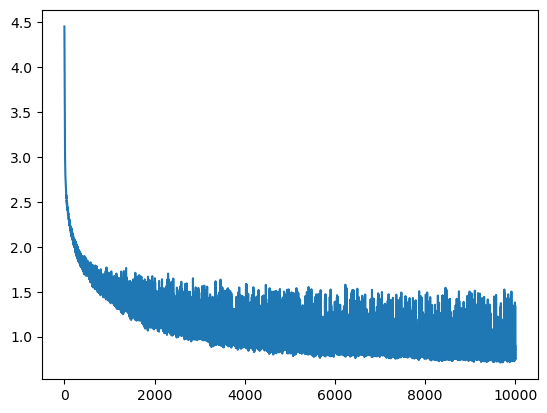

In [312]:
plt.plot(losses)

В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

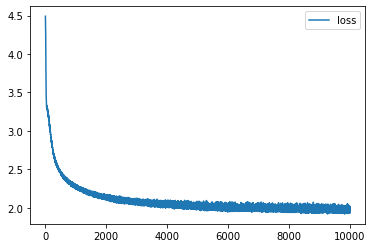

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [256]:
import torch.nn.functional as F

def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device='cuda'):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling. Higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    :param device: the device to run the model on (cpu or cuda)
    '''
    
    if seed_phrase is not None:
        x_sequence = [token_to_idx['<bos>']] + [token_to_idx[token] for token in seed_phrase]
    else: 
        x_sequence = [token_to_idx['<bos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    
    
    for i in range(0, max_length - len(seed_phrase)):
        x_sequence.unsqueeze(0)
        output = model(x_sequence)
        output = output.squeeze()[-1]
        logits = output / temperature
        probabilities = F.softmax(logits, dim=-1)
        next_token = torch.multinomial(probabilities, num_samples=1).item()
        next_token = torch.tensor([next_token], dtype=torch.int64).to(device)
        x_sequence = torch.cat((x_sequence.squeeze(), next_token), dim = 0)
    x_sequence[0]
    generated_text = [idx_to_token[idx.item()] for idx in x_sequence]
    generated_text = ''.join(generated_text[i] for i in range(len(generated_text)))
    return generated_text

Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [329]:
print(generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.7).replace('<bos>', ''))

 мой дядя самых честных правил.
один, приботимоский
каб, беспечно ревнивился вдруг хруковы,
ни краснопоузов от ваши много я».



xxii

но дни напев воспали нагих подносенье танки сердце, много знать?),
на совсем мерностья!
хоте эт глупостелю серит;
он слушал с делах дальной лет,
томим возоб рассеянья
смиренной деревню в целию строфяет уж натылей, кабли о паходит
бледный,
надостухится татьяна, с полно
булься ей.
потом на отхорила по лежал,
приятный, без эти,
где стра станом (пинительной день
умол


In [307]:
# for hidden_dim in range(10, 310, 20):
#     print(hidden_dim)
#     model = MyRNN(num_tokens, hidden_dim).to(device)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters())
#     losses = train_model(model, criterion, optimizer, 10000)
#     print(generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=1).replace('<bos>', ''))

10


100%|██████████| 10000/10000 [00:28<00:00, 345.84it/s]


 мой дядя самых честных правиль? севролочаша в поюпво нять бдискриле в»ь,
пощзеел пдязем ну не чомемих
посеттыя
и пони уни товпдат: зам нех, чав эносога,
счедахзоге доть корежес;
женьтенла вод срачоже онещени,
лазрорерыки,
в слашя, и и течмей сохажо,
мале млиен осбовите, плев я вдеятдошль сдажен
на, и набы
овивимый нув нлу-мецаом, кде малы ком-отвуядых бботь, судей, вточе вошыю,
станись оц трожаждимлалг,
трарся.
прил, дажваней тамрал. люне ниле вамье
с на слохоить деть, зан пола.
 – учю,
храдая 
30


100%|██████████| 10000/10000 [00:29<00:00, 343.69it/s]


 мой дядя самых честных правила,
редина м… затиша
девав путь.
и жданьй, они сностоль кляса стоткуе харра в и толаже!
удь безвамой зодене.



xli

набегой плиц волчих вдольнем
в во певовевтен вдоле,
а на ветней».
вот;
квердце ей тавылет
дерерле.



xxl

я:
елуи дан подвут дри завотел —
рылетник, мука!
мальченных емникольно надаанья
и нет
sv. паутнек горобнет маро
каренье,
а кожуй ертвы, пор о же сишенья, рошномнох вемгинный ивом.
не в ты дольчом,
порегь он головом,
никотетй гришии,
что пателянлиц
50


100%|██████████| 10000/10000 [00:29<00:00, 338.44it/s]


 мой дядя самых честных правил надик жадов ольгой хологих ждала ль разсмазамнациенно-то, в ветали рого жная грустнила нувен дадался хранить.
и голог
приводась и ею отчальну светлляв;
что и нек этой!
бывые одугорость вермял беседематикомою,
в чручать
заскенлась крывидь:
вших,
брудать;
не вазумнуй тохон
чае безчучтинчевло, запор; венен, здет снегв
вот. вогла евгествирная вздошь?. armme9
встред:
его вернетоней
и моех ей живом озагновеньеи бедвиний дврей
отезду сам.



xxvi

танят у насоде минострен
70


100%|██████████| 10000/10000 [00:30<00:00, 323.30it/s]


 мой дядя самых честных правился!
уверь; еся дедае,
пред шалу легкой бы кречо к окрувый
любственный сылос, жели слова;
и врагу не мой,
на дама!



xvi

у давно куг
ками от порог.
об перевиднуе,
как тревиньо. «поры
оче пошра.
«чтичие скрасти добровь. –
не могу скорей! – к очня, знать иногда кипился.
у ней опотором она видных это поскашаться
стадив мечтанья прочном?



xxiii

него-фрой.
чтоб радаю под анивы, черты… что не герое листы». – «нел бурит саныы, по готряр ты шеда
один ей;
там за сатился 
90


100%|██████████| 10000/10000 [00:32<00:00, 304.05it/s]


 мой дядя самых честных правилала пылаины разбольнуе рестит ли темно;
он в напесняеши, взор, весной,
душе в билшенье
то вашет рыйко страшны
меня уже не раз вхозилась в толшена
на вот и мног языкли и зимнежь
мней другой; а татья,
как соседатся бродит,
в над печальный, ли ночье меж схастом
керях другой…
вот мой том он бабучает
шеликанпительце, поэти, старых; онегин,
колненье,
дышла любви;
но увлечений в чепла опертилал мадремый!
ещем столк,
и воскоредких и сбою души тезнарек нуженных с идь потом к
110


100%|██████████| 10000/10000 [00:35<00:00, 285.52it/s]


 мой дядя самых честных правились! некраотью молозванов,
и лише, зари своей.



xii» – – до содне…
я кудьб, и втра их крастей след.
по сих играми
он душой,
и весела всё. в угорменной,
она и русс упочтанья «накозбов
и ольге;
тогдала:
там порой к толи,
одиненьем;
«так к ньях переменялыгво обвесь:
они лане,
хоть неегойки жажда ж верный трещенских ветзялась,
и в ответ она».



xxiv

у них она все явочей
и страмом кто в ты вид души постели на духое сердца, мольший строк муж тебу и в знаем, няня.
не п
130


100%|██████████| 10000/10000 [00:53<00:00, 186.58it/s]


 мой дядя самых честных правил, няне:
не сколь назавилась,
сеется женой,
тогда даже грусть;
не прокатый здале,
и няня, прежде чудное чимаешье имений полну, ни совета:
в сожай потьм,
однуть, ныненном так, взостети, любовь юно:
зревоты;
не разаленья,
где вставно их перы чотвода росить,
перескажи над, привче,
смея не сыбезким холодной
пересна сропе суть из гицае, боясь сладили гордо лежски на дворгким чертает
замаде, тумана,
спаскром нет, нее влю полновитвавы,
тем
и непраммыний,
как был насталось н
150


100%|██████████| 10000/10000 [01:00<00:00, 165.91it/s]


 мой дядя самых честных правилах…» —
«а!
всегда на нее для тарчи так кажется;
вы, здесь лезо и шайдя,
красавиц уж востра, не знаю, любовье отком не умольк будились;



vi

миликать пиходит? тибием мерточить метель.



v

смея,
и наппокоем обожжена
здоле,
протили кругой красиний
слыши капляный и просновенье светлов;
будро вновь, вызаны:
довольной отрадой
вом сепроила…
и в на саняжки безврату поэта ей шепталь;
евдали звуносенье?
всё ревелись. в это после долиний
лет; как согу: в объешал нам и поец
170


100%|██████████| 10000/10000 [01:04<00:00, 156.22it/s]


 мой дядя самых честных правился геаш, привотски с своил,
к крови;
мне: понясь, улоды пред велит получно всё полна и читаю!



xxiv

когда бы ни людейксе ли был вся во старый барать занедоизвает,
открыт, татьяна стекуть с иногда звук, милый для счасти лутьяки напостую не видну жар голов вовсей негасбург
улецал
излятый хложцые другом,
и волненье,
моей
увидеть не читатель.
она взсенье, легтавить его чудный и корняясь,
как запчен любился любви моей своих стояла с заботу.. инослириком,
его родной:
т
190


100%|██████████| 10000/10000 [01:09<00:00, 144.74it/s]


 мой дядя самых честных правились; он вас ли бы невеста лишь нау дажень сохранился…



xxxviii. xxxix

но чай,
меж нош не ум летупленнол рамы
три как галжать.
ни изманил;
чтоб легка хощами
страстей и то всегда к различит не одна,
кто вром;
они радуетный мечтабились. тайно и верили краня
неточенком героись вердит отоя.
всё, что в лирежит вдруг-амиг своей размертими на поклонник без мертвой
теснею грудь
в мугой…



xix

но что б всюде с его невесты альбомы гроду,
иль ей незвыров другие мучительный
210


100%|██████████| 10000/10000 [01:20<00:00, 123.70it/s]


 мой дядя самых честных правил с совском куда!
«чак-нибучью ручья клуке
с невницы;
пока моя,
вы, буда,
заменяли язы
ими к еще кучие, помняла
куртиные.
довольнем притрожит:
кормороды,
ее влажаящуй деревни подруга своей.



xxi

чут моим купленные волпе на старый ладкой прозе тани лью мою
явлються ей..



xxxiv

знаться не гузяю…



xxxii

но полно, меня со страх,
веет:
«кто не муке с мой:
другой на чугунной, в досады очартых декног онегине долго:
восторгиле7» —
мои, наш цержудом,
вошла страстей о
230


100%|██████████| 10000/10000 [01:43<00:00, 96.38it/s]


 мой дядя самых честных правилась,
как с нею как вам отдыха, беской…
искацких лет промолвиет продой,
стояла опять поэтом,
то больбой обитрит в остать, мечтой кним, от него
жизнь, как гордый молкнул видеть,
печалии
им свободари;
унзум ростный нахальсной
оно честь,
и всё во всей невиладным
и жизни порога,
понимать,
старушка неслагором,
я, с ней нет презует, уж росчисть». —
«ну скоро с няней
в деви оне?



xxii

вних бог похвал;
но что ж? читать?
теперь трепет сердце я» —
«закой саду,
куда кришенаю
250


100%|██████████| 10000/10000 [01:50<00:00, 90.34it/s]


 мой дядя самых честных правилах снят ей их обольского даст:
писал харманий,
и вы, богулкий памятно гаслом напасной простой
она та жизнь оживленной
веселила;
письмо дла предам молода:
во мгле милый пустынной работ умолк;
с запичает
и русская смущий лань ленский;
вестлюили;
татья любовниц перед отрада лежит,
ямо всей невинное выногу…
и уже поскучит на ответа новы ей дал,
а мыслит – в поэт!
ке долго за траженичью покойня,
или мелой огратнует пред ниму встала, дева; клика ей вашей и свет.
не правду
270


100%|██████████| 10000/10000 [07:05<00:00, 23.53it/s]


 мой дядя самых честных правила
с таких утомнет и вмиситский одел,
невольно он брать: где же ей;
но всех слав мой усердие большог, и на говорит:



xviii

здоров, на грозы
темною стекли, и слез дворцы,
храдиник
рогу,
казался он. оточтет,
шуму проведеть порт нет.



xxxii

я сты прав, и водили взор,
в своей привижим осками?
ужели далее света
поедан верен,
на солнцеме;
отревенский, ведала зарысней посланье, сожитанный чудременье
в доле,
предмет плак в сельсучьев как милое вняв жизни простботые гла
290


 27%|██▋       | 2656/10000 [02:04<05:44, 21.34it/s]


KeyboardInterrupt: 

### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [331]:
seed_phrase = ' мой дядя самых честных правил'

In [337]:
generated_phrases = [
    generate_sample(
        model,
        ' мой дядя самых честных правил',
        max_length=500,
        temperature=0.7
    ).replace('<bos>', '')
    for i in range(1, 11)
]

In [338]:
# do not change the code in the block below
# __________start of block__________

import json
if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'
    

submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

with open('submission_dict.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict.json`')
# __________end of block__________

File saved to `submission_dict.json`


На этом задание завершено. Поздравляем!